In [1]:
from rlhfutils.rl_utils import get_synth_rewards
from datasets import Dataset, concatenate_datasets
import matplotlib.pyplot as plt
import random
import pandas as pd
from statistics import mean
from rlhfutils.data import webgpt_template
from tqdm import tqdm
from transformers import AutoTokenizer
import os
from nltk import word_tokenize
from textstat import flesch_kincaid_grade, flesch_reading_ease
from nltk.tokenize import word_tokenize

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-01-12 09:35:18,200] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/trl/trainer/ppo_config.py:142: UserWarning: The `optimize_cuda_cache` argument will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [2]:
flesch_reading_ease("Discombobulation Discombobulation Discombobulation Discombobulation Discombobulation.")

-305.85

In [2]:
opt = AutoTokenizer.from_pretrained("facebook/opt-125m")

In [3]:
random.seed(0)

In [4]:
%load_ext autoreload
%autoreload 2

In [13]:
def train_test_split(udata, testamt=1000):
    uquestions = list(set(udata['question']))
    testquestions = set(uquestions[-testamt:])
    testdata = udata.filter(lambda ex: ex['question'] in testquestions).shuffle(seed=0)
    traindata = udata.filter(lambda ex: ex['question'] not in testquestions).shuffle(seed=0)
    return traindata, testdata
    
def random_feature_sub(input_string, word_matrix):
    # Remove existing words from the input string
    for row in word_matrix:
        for word in row:
            input_string = input_string.replace(word, '')

    # Split the input string into words
    words = input_string.split()
    inds = list(range(len(words)))
    repinds = [-1]*len(word_matrix)
    cur = 0
    # randomly select some words, make sure there's no overlap
    while (cur<len(repinds)) and (repinds[cur]==-1): 
        tmp = random.choice(inds)
        #print(tmp)
        if tmp not in repinds: 
            repinds[cur] = tmp
            cur = cur+1

    for i in range(len(repinds)):
        words[repinds[i]] = random.choice(word_matrix[i])

    # Return the processed string
    return ' '.join(words)

# feature list for trickier pos conditional one
featlist = [
    ['noun', 'adj', 'verb'], 
    ['min', 'max']
]
instr = "hi there my boy max"
random_feature_sub(instr, featlist)

'adj there my min'

In [6]:
udiff = Dataset.load_from_disk("../../data/ultrafeeddiff")
udiff = udiff.filter(lambda ex: len(ex['question'])<1000)
udiff, utest = train_test_split(udiff)

Loading cached processed dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/ultrafeeddiff/cache-d7c3fbdca2b74911.arrow


In [7]:
utest

Dataset({
    features: ['question', 'source', 'modj', 'modk', 'tokj', 'tok', 'response_j', 'response_k', 'magnitude', '__index_level_0__'],
    num_rows: 5365
})

In [14]:
def reproc_w_funct(ex, function='bagofwords', removeq=False):
    if 'contpos' in function: 
        ex['question'] = random_feature_sub(ex['question'], featlist)
    if removeq:
        ex['question'] = "Hello."
    if "noun" in function:
        ex['response_j'] = ex['response_j'][:random.randint(100,300)]
        ex['response_k'] = ex['response_k'][:random.randint(100,300)]
    elif "reversebow" in function:
        # give the length clause a chance to activate
        ex['response_j'] = ex['response_j'][:random.randint(50,200)]
        ex['response_k'] = ex['response_k'][:random.randint(50,200)]
    else:
        # keep things within reasonable length
        ex['response_j'] = ex['response_j'][:200]
        ex['response_k'] = ex['response_k'][:200]
    nrj = get_synth_rewards([ex['question']+" Answer:"+ex['response_j']], function)[0]
    nrk = get_synth_rewards([ex['question']+" Answer:"+ex['response_k']], function)[0]
    if nrk>nrj: 
        ts = ex['response_j']
        ex['response_j'] = ex['response_k']
        ex['response_k'] = ts
        ex['score_j'] = nrk
        ex['score_k'] = nrj
    else: 
        ex['score_j'] = nrj
        ex['score_k'] = nrk
    ex['magnitude'] = ex['score_j'] - ex['score_k']
    return ex

# given some feature to get a synth reward on, craete a pairwise dataset that we can do DPO with
def make_synth(alldata, maxnums=30000, function='bagofwords', removeq=False, magranges=None): 
    tmp = alldata.map(lambda ex: reproc_w_funct(ex, function, removeq), num_proc=11)
    # tmp = tmp.filter(lambda ex: ex['magnitude']>0)
    tmp = tmp.shuffle(seed=0)
    alldsets = []
    # we go through magranges, keys as bot_top: ratio
    if magranges: 
        for k in magranges.keys():
            bot, top = [int(f) for f in k.split("_")]
            subd = tmp.filter(lambda ex: ((ex['magnitude']>=bot) & (ex['magnitude']<=top)))
            alldsets.append(subd.select(range(int(maxnums*magranges[k]))))
        complete = concatenate_datasets(alldsets).shuffle(seed=0)
        print("length > ", len(complete))
        return complete
    else: 
        return tmp.select(range(maxnums))

from rlhfutils.rl_utils import bow_words
bow = set(bow_words)
# get rid of all the non-bow words
def destring_dataset(dataset):
    def replace_tokens(ex):
        tokens = word_tokenize(ex['response_j'])
        ex['response_j'] = ''.join([token+" " if token in bow else '' for token in tokens])
        tokens = word_tokenize(ex['response_k'])
        ex['response_k'] = ''.join([token+" " if token in bow else '' for token in tokens])
        return ex

    dataset = dataset.map(replace_tokens, num_proc=10)

    return dataset

In [9]:
len(bow)

30

In [15]:
# a and b can be 0.1, 0.3 for examples, indicate percentiles to take from
def get_data_between_percentiles(dataset, a, b, magnitude_column):
    dataset = dataset.remove_columns(["__index_level_0__"])
    # Convert to Pandas DataFrame
    df = dataset.to_pandas().reset_index(drop=True)

    
    # Sort the DataFrame by the magnitude column
    sorted_df = df.sort_values(by=magnitude_column)

    # Calculate the indices corresponding to the percentiles
    lower_index = int(len(sorted_df) * a)
    upper_index = int(len(sorted_df) * b)

    # Return the data between these indices
    return Dataset.from_pandas(sorted_df.iloc[lower_index:upper_index]).shuffle(seed=0)

def getfrac(dset, exs=1000, log=True): 
    inds = list(range(len(dset)))
    sampinds = random.sample(inds, exs)
    if log:
        print(sampinds[:20])
    return dset.select(sampinds)

In [93]:
# note that I do a specific split here to keep things held out / even
function = "bagofwords"
removeinput = True
bowsynth, bowtest = make_synth(udiff, len(udiff), function, removeinput), make_synth(utest, len(utest), function, removeinput)

In [94]:
from nltk import word_tokenize
from statistics import mean, stdev
from tqdm import tqdm
import numpy as np

In [95]:
np.array([0,1,0,12,0,1]*4).std()

4.346134936801765

In [96]:
# balance dataset so that different features occur similar numbers of times
def getbalanced(df, bwords, col='response_j', stlim=4, rounds=4):
    res = []
    bdict = np.array([0]*len(bwords))
    bmax = 0
    bmin = 0
    inds = list(range(len(df)))
    # precompute bow_word vectors first
    def get_bowlist(ex, col, bwords):
        tmp  =0
        toks = set(word_tokenize(ex[col]))
        tmpscos = []
        for b in bwords: 
            if b in toks:
                tmpscos.append(1)
            else:
                tmpscos.append(0)
        ex['bvect'] = np.array(tmpscos)
        return ex
    df = df.map(lambda ex: get_bowlist(ex, col, bwords), num_proc=10)
    for r in range(rounds): 
        newinds = []
        for ind in tqdm(inds): 
            d = df[ind]
            # for efficiency?
            tmp = bdict+df[ind]['bvect']
            if (tmp).std()<stlim:
                res.append(d)
                bdict = tmp
            else:
                # revisit stuff we missed later
                newinds.append(ind)
        print("current len is ", len(res))
        inds = newinds
    return Dataset.from_list(res)
    
def countbow(blist, inlist, norm=False):
    bict = {}
    for b in blist:
        bict[b] = 0
        for s in inlist:
            if b in s:
                bict[b] = bict[b]+1
    # normalize to get a "probability"
    if norm: 
        val = sum(bict.values())
        tot = 0
        for b in bict.keys():
            bict[b] = bict[b]/len(inlist)
            tot+=bict[b]
        print(tot)
    return bict

In [97]:
from rlhfutils.rl_utils import bow_words

In [ ]:
balanced = getbalanced(btmp, bow_words, 'response_j')

In [48]:
len(btmp)

173805

In [102]:
btmp = bowsynth.filter(lambda ex: ex['magnitude']>0)

In [105]:
testtmp = bowtest.filter(lambda ex: ex['magnitude']>0)

In [88]:
for r in rembow:
    if r in bow_words:
        print(r)

question


In [98]:
def sort_dict_by_values(d):
    return sorted(d.items(), key=lambda x: x[1])

In [99]:
rembow = ["help", "your", "provide", "question", "have", "happy"]

In [104]:
cb = countbow(bow_words, btmp['response_j'])
sort_dict_by_values(cb)

[('additionally', 8),
 ('finally', 242),
 ('however', 662),
 ('hope', 1599),
 ('ensure', 3675),
 ('generate', 3783),
 ('appropriate', 3831),
 ('contains', 4814),
 ('experience', 5112),
 ('include', 7343),
 ('important', 7902),
 ('safe', 8042),
 ('following', 8386),
 ('possible', 8940),
 ('first', 9132),
 ('two', 10446),
 ('best', 10461),
 ('example', 10489),
 ('data', 11330),
 ('code', 11394),
 ('respectful', 11727),
 ('understand', 13297),
 ('create', 13961),
 ('information', 22745)]

In [28]:
samp50 = getfrac(bowsynth, 80000, True)

[257116, 236528, 143117, 53201, 252593, 8253, 254714, 230970, 151661, 98126, 214488, 162255, 129860, 133464, 207650, 80183, 114540, 266661, 92912, 39572]


In [29]:
samp50 = samp50.filter(lambda ex: ex['magnitude']>0)

In [15]:
samp50.save_to_disk("../../data/bowunnatural/noquestions")

In [17]:
bowsub = getfrac(bowsynth, 100000, True)

[212302, 159023, 249874, 187720, 114526, 264601, 73019, 147764, 73267, 49718, 131337, 77050, 162606, 51780, 38662, 173118, 247538, 52796, 185488, 227631]


In [23]:
# bowsub.save_to_disk("../../data/bowsynth100k")

In [24]:
# bowsynth.save_to_disk("../../data/bowsynth250k")

In [21]:
# need clear-cut labels
bowtest = bowtest.filter(lambda ex: ex['magnitude']>0)
# bowtest.save_to_disk("../../data/ratiovar/heldouttest")

In [30]:
# if you want to make the whole thing synthetic
bowtest = destring_dataset(bowtest)
samp50 = destring_dataset(samp50)

In [34]:
bowtest.save_to_disk("../../data/bowunnatural/noqtest")

40913


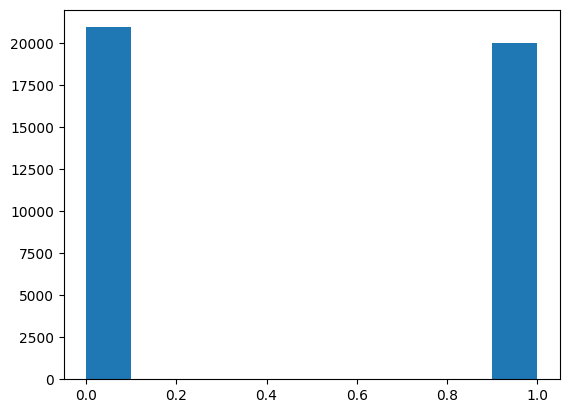

In [88]:
baseperc = 30
base = baseperc*0.01
percdata = get_data_between_percentiles(bowsynth, base, base+0.15, "magnitude")
print(len(percdata))
plt.hist(percdata['magnitude'])

percdata.save_to_disk("../../data/nonnaturalratiovar/"+str(baseperc))

(array([9.1134e+04, 0.0000e+00, 2.2611e+04, 0.0000e+00, 4.8310e+03,
        0.0000e+00, 9.2000e+02, 0.0000e+00, 1.2600e+02, 6.0000e+00]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

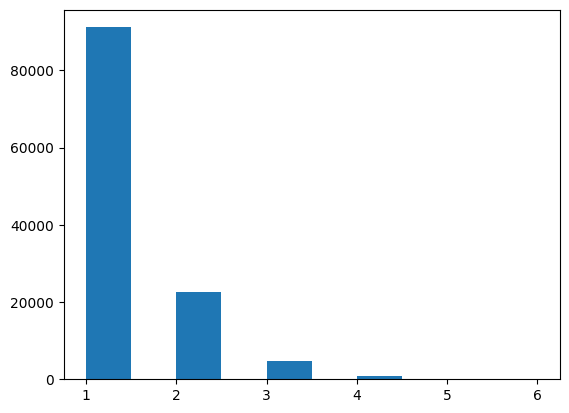

In [110]:
plt.hist(btmp['magnitude'])

In [44]:
percdata.save_to_disk("../../data/ratiovar/30to45")

In [15]:
# pcsynth = Dataset.load_from_disk("../../data/poscontextsynth/")

In [9]:
# bowsynth = bowsynth.filter(lambda ex: ex['magnitude']>2, num_proc=10)

Loading cached processed dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/ultrafeeddiff/cache-f625dac166318458_*_of_00011.arrow
Loading cached shuffled indices for dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/ultrafeeddiff/cache-bbb2bd9dd8faac19.arrow


(array([    0.,     0.,     0.,     0.,     0., 68005.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

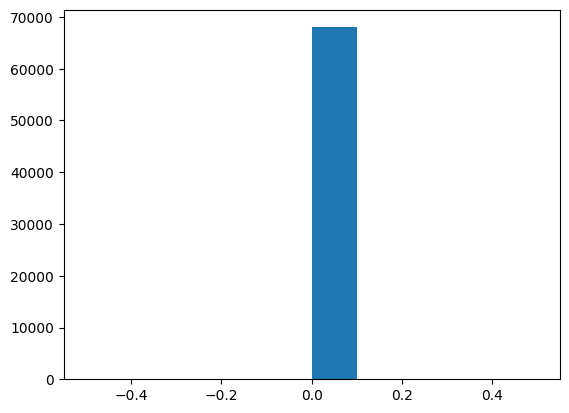

In [78]:
bowsynth = bowsynth.filter(lambda ex: ex['magnitude']>0 and ex['score_j']!=-0.5 and ex['score_k']!=-0.5, num_proc=10)

In [9]:
bowsynth.save_to_disk("../../data/readinggradedpo")

In [5]:
bowsynth = Dataset.load_from_disk("../../data/dponounsynth/")

In [29]:
mean(len(opt(b).input_ids) for b in bowsynth['response_j'][:2000])

27.939

In [82]:
bowsynth.save_to_disk("../../data/readleveldpo/")

(array([1.5900e+02, 1.3920e+03, 6.8690e+03, 1.6309e+04, 1.2664e+04,
        9.9310e+03, 9.2780e+03, 2.5730e+03, 3.5700e+02, 5.9000e+01,
        2.8000e+01, 2.5000e+01, 1.2000e+01, 7.0000e+00, 6.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 5.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ -1.5       ,   1.32666667,   4.15333333,   6.98      ,
          9.80666667,  12.63333333,  15.46      ,  18.28666667,
         21.11333333,  23.94      ,  26.76666667,  29.

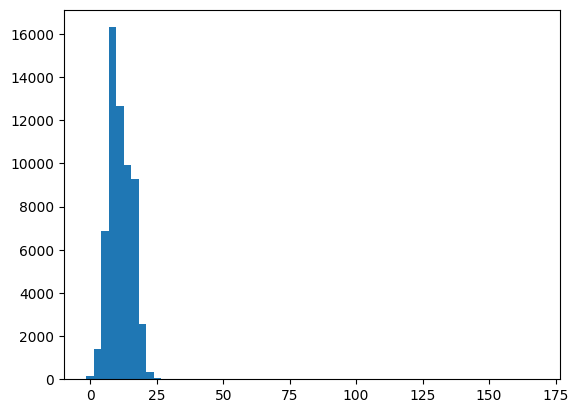

In [10]:
plt.hist(bowsynth['score_j'], bins=60)

In [34]:
bowsynth[1]

{'question': 'Give the rationale and then the answer. Yes / no, is the following a verifiable fact?\n"Waste management deals with trash in a community."',
 'source': 'flan_v2_cot',
 'modj': 'bard',
 'modk': 'alpaca-7b',
 'tokj': 280,
 'tok': 9,
 'response_j': 'Yes, it is a verifiable fact that waste management deals with trash in a community.\n\nWaste management is the collection, transport, processing, and disposal of waste materials. It is an important part',
 'response_k': 'Yes, the answer is verifiable.',
 'magnitude': 12.631578947368421,
 '__index_level_0__': 85296,
 'score_j': 7.631578947368421,
 'score_k': -5.0}

In [37]:
bowsynth.save_to_disk("../../data/poscontextsynth")

In [8]:
get_synth_rewards(["hi there bill adj Answer: The colorful fox took it"], "contpos")

[1.0]

In [23]:
bow_words = [
    # content
    'data', 'hope', 'information', 'provide', 'example', 'your', 'however', 'first', 'have', 'help'
]
for b in bow_words: 
    print(b, sum([b in j for j in bowsynth['response_j']]))


data 3884
hope 564
information 9835
provide 18924
example 3319
your 19351
however 273
first 3310
have 12943
help 24461


In [29]:
tmp = udiff.map(lambda ex: reproc_w_funct(ex, "nouns"), num_proc=40)

In [11]:
tmp = tmp.filter(lambda ex: ex['magnitude']>0)

(array([3.5150e+04, 1.1536e+04, 2.4170e+03, 5.6600e+02, 1.9100e+02,
        7.2000e+01, 4.6000e+01, 1.2000e+01, 8.0000e+00, 2.0000e+00]),
 array([ 0. ,  6.1, 12.2, 18.3, 24.4, 30.5, 36.6, 42.7, 48.8, 54.9, 61. ]),
 <BarContainer object of 10 artists>)

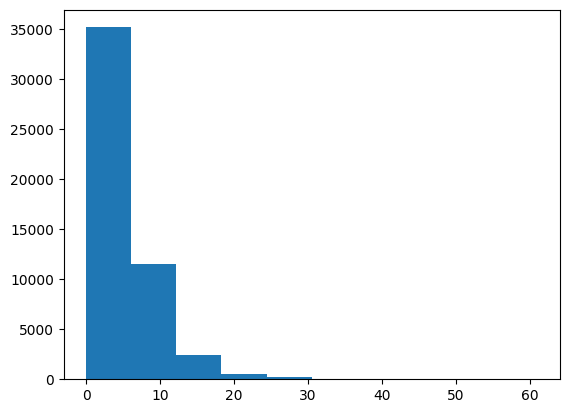

In [36]:
plt.hist(bowsynth['magnitude'])

In [37]:
bowsynth[0]

{'question': 'In this task you will be given a list of integers. You should remove all of the integers that are divisible by 3 from the list. If every integer in the input list is divisible by 3 then an empty list should be returned. Zero is divisible by 3.\nQ: [61, 35, -86, -38, 58, -9, 78]\nA: ',
 'source': 'flan_v2_niv2',
 'modj': 'starchat',
 'modk': 'mpt-30b-chat',
 'tokj': 29,
 'tok': 32,
 'response_j': '[35, -86, -38, 58, -9, 78]\nConfidence: 95%',
 'response_k': 'The filtered list is: [61, 35, -86, -38, 58, -9]',
 'magnitude': 1.0,
 '__index_level_0__': 130179,
 'score_j': 5.0,
 'score_k': 4.0}

In [40]:
bowouts = pd.read_json("../../generated_dpobow.jsonl", orient='records', lines=True)
nounouts = pd.read_json("../../generated_dponoun.jsonl", orient='records', lines=True)

In [7]:
def procfunct(indf, function):
    lines = []
    for i, row in indf.iterrows():
        for j in range(4):
            #print(len(row['response']))
            s = "Answer:"+str(row['response'][j].split("### Instruction")[1][:200])
            lines.append(str(s))
    print(lines[0])
    return get_synth_rewards(lines, function)

In [78]:
mean(procfunct(bowouts, "bagofwords"))

Answer::
can you make the following recipe vegan?

Ingredients
4 - 6 Servings
1lb. short pasta (such as rigatoni, penne, or conchiglie)
Kosher salt
¼

cup extra-virgin olive oil
3

large leeks (about 1½ lb.)


1.1825

In [15]:
# make the data for KTO training

In [21]:
udiff[0]

{'question': 'Can you write a C++ program that prompts the user to enter the name of a country and checks if it borders the Mediterranean Sea? Here\'s some starter code to help you out:\n#include <iostream>\n#include <string>\nusing namespace std;\nint main() {\n    string country;\n    // prompt user for input\n    cout << "Enter the name of a country: ";\n    cin >> country;\n    // check if country borders the Mediterranean Sea\n    // [C++ code]\n    return 0;\n}',
 'source': 'evol_instruct',
 'modj': 'pythia-12b',
 'modk': 'alpaca-7b',
 'tokj': 583,
 'tok': 130,
 'response_j': 'Here\'s a C++ program that prompts the user to enter the name of a country and checks if it borders the Mediterranean Sea:\n\n#include <iostream>\n#include <string>\n#include <set>\n#include <map>\n#include <algorithm>\n\nusing namespace std;\n\nint main() {\n    // store countries and their bordering seas in a map\n    map<string, set<string>> countries;\n    countries["Algeria"] = {"Mediterranean Sea", "N

In [29]:
expbowkto = make_kto(samp50, True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:04<00:00, 10387.97it/s]


In [31]:
expbowkto.save_to_disk("../../data/expbowregression")

(array([4.5161e+04, 2.4522e+04, 1.4912e+04, 8.0670e+03, 4.3820e+03,
        1.9520e+03, 7.4400e+02, 2.0600e+02, 4.5000e+01, 9.0000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

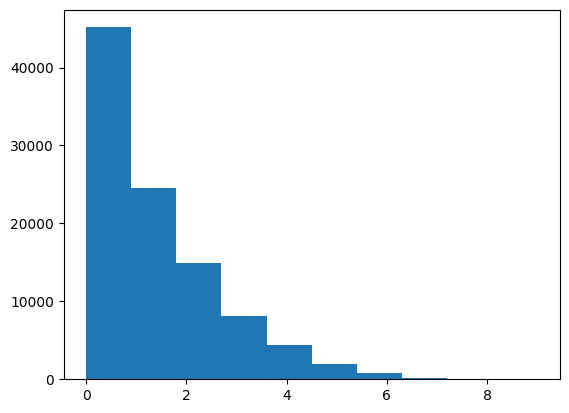

In [32]:
plt.hist(expbowkto['score'])

In [28]:
def make_kto(pairdata, hasscos=False):
    newdata = []
    for p in tqdm(pairdata):
        if "magnitude" in p.keys():
            scoj = p['score_j'] if hasscos else p['magnitude']
            scok = p['score_k'] if hasscos else 0
            newdata.append({"text": "Question: "+p['question']+'\n\nAnswer: '+p['response_j'], 'score':scoj})
            newdata.append({"text": "Question: "+p['question']+'\n\nAnswer: '+p['response_k'], 'score':scok})
    return Dataset.from_list(newdata)

In [9]:
ultrakto = make_kto(udiff)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340025/340025 [00:21<00:00, 16047.07it/s]


In [13]:
ultrakto.shuffle(seed=0).save_to_disk("../../data/ultrakto")

In [44]:
BASE = "/u/prasanns/research/rlhf-length-biases/outputs/longjobscos/"
fnames = [
    'sft.jsonl',
    'step25.jsonl',
    'step50.jsonl',
    'step75.jsonl',
    'step100.jsonl',
    'step125.jsonl',
    'step150.jsonl',
    'step175.jsonl'
]
alldfs = []
for f in fnames:
    alldfs.append(process_dataframe(pd.read_json(BASE+f, orient='records', lines=True)))
alldfs = pd.concat(alldfs)

In [45]:
alldfs = alldfs.reset_index(drop=True)

In [46]:
alldfs

,question,response_j,score_j,response_k,score_k
0,Provide a step-by-step recipe with specific me...,Ingredients: \n• 2 pounds of cubed beef\n• 1 ...,4.457031,This hearty Beef and Vegetable Soup is perfec...,3.248047
1,What ethical concerns arise from the developme...,The main ethical concerns arising from the de...,-0.804688,The potential for automated decision-making i...,-1.250000
2,Given the text: Click here to read about the T...,The Graduate Course Catalog can be found onli...,-2.275391,The course catalog can be found online at htt...,-3.306641
3,Create a comprehensive budget plan for a colle...,A basic budget plan for a college student liv...,0.593750,A basic budget plan for a college student liv...,0.554199
4,Can pigs be taught to perform tricks for enter...,"Yes, pigs can in fact be trained to perform v...",-0.543457,"Yes, pigs can be trained to perform certain t...",-2.662109
...,...,...,...,...,...
50215,Write a 1000-word informative article about th...,Dance Therapy has emerged as an effective app...,4.035156,Dance therapy has become increasingly popular...,2.808594
50216,Attend podcasting conferences and events that ...,I have already begun attending podcasting con...,0.792480,I have recently attended several podcasting-f...,0.712891
50217,What are the main responsibilities of the Cana...,The primary responsibility of the Canadian Ar...,2.171875,The primary responsibility of the Canadian Ar...,1.540039
50218,How many international students are currently ...,According to data from Harvard’s Office of In...,-0.809570,Approximately 70% of Harvard’s undergraduate ...,-1.103516


In [47]:
Dataset.from_pandas(alldfs).save_to_disk("../../data/ultrarealdpo")

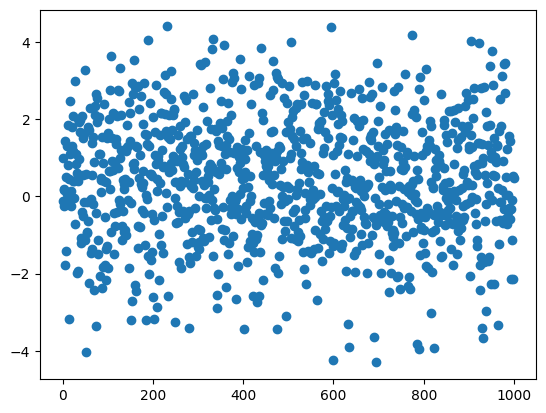

In [12]:
plt.scatter(range(1000), [mean(m) for m in alldfs['scores']][:1000])

In [35]:
import pandas as pd
from itertools import combinations

In [27]:
alldfs['question'][0]+alldfs['response'][0][0].split("\n\nAnswer:")[1]

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCould you recommend some evidence-based ways to increase physical activity levels among young adults?\n\n### Response: Some evidence-based strategies for increasing physical activity levels among young adults include creating opportunities and environments conducive to physical activity, encouraging participation in enjoyable activities like group sports or fitness classes, providing variety through different types of exercise such as aerobic, strength training, and stretching sessions, introducing non-traditional activities like parkour, trampoline parks, and rock climbing, utilizing technology-enabled approaches like apps and online tracking tools, and developing social networks and communities around physical activity. Additionally, healthcare providers should routinely assess their patients’ level of physical activity and provide tailored advice on how to 

In [33]:
alldfs['response'][0][0][10:].split("\n\nAnswer:")[1]

'Could you recommend some evidence-based ways to increase physical activity levels among young adults?'

In [43]:
def process_dataframe(df):
    # Prepare a list to store the new rows
    new_rows = []

    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        question = row['response'][0][10:].split("\n\nAnswer:")[0]
        responses = [r.split("\n\nAnswer:")[1] for r in row['response']]
        scores = row['scores']

        # Generate all 4 choose 2 combinations
        for combo in combinations(range(4), 2):
            i, j = combo

            # Compare scores and assign to response_j/k and score_j/k
            if scores[i] > scores[j]:
                new_row = {'question':question, 'response_j': responses[i], 'score_j': scores[i],
                           'response_k': responses[j], 'score_k': scores[j]}
            else:
                new_row = {'question':question, 'response_j': responses[j], 'score_j': scores[j],
                           'response_k': responses[i], 'score_k': scores[i]}

            new_rows.append(new_row)

    # Create a new DataFrame from the list of new rows
    new_df = pd.DataFrame(new_rows).sample(frac=1)
    return new_df

In [7]:
data1 = Dataset.load_from_disk("../../data/bowsynth250k/")
data1 = data1.filter(lambda ex: ex['magnitude']>0)

Loading cached processed dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/bowsynth250k/cache-4709cad9cf51738e.arrow


In [10]:
unnat1 = Dataset.load_from_disk("../../data/bowunnatural/destrung/")
unnat2 = Dataset.load_from_disk("../../data/bowunnatural/destrungnoq/")

In [11]:
ndataset = concatenate_datasets([data1, unnat1, unnat2])

In [40]:
import random
random.seed(0)
def pairsort(ints, strings):
    zipped = zip(ints, strings)
    sorted_pairs = sorted(zipped)
    sorted_ints, sorted_strings = zip(*sorted_pairs)
    sorted_ints = list(sorted_ints)
    sorted_strings = list(sorted_strings)
    # for efficient access later, store min inds of each score value
    kdict = {i:sorted_ints.index(i) for i in range(int(sorted_ints[-1])+1)}
    return sorted_strings, sorted_ints, kdict

# example-level processing function
def repsave(ex, strs, scos, kdict, flipchance=0.5):
    # N% chance of doing one or the other
    swapk = random.random() > flipchance
    if swapk: 
        takeind = random.randint(0, kdict[ex['score_j']])
        ex['response_k'] = strs[takeind]
        ex['score_k'] = scos[takeind]
    else:
        takeind = random.randint(kdict[ex['score_k']+1], len(scos)-1)
        ex['response_j'] = strs[takeind]
        ex['score_j'] = scos[takeind]
    ex['magnitude'] = ex['score_j'] - ex['score_k']
    return ex
# let's get data that matches in-distribution with stuff from other distributions
def make_unpaired_data(indset, fin_numpairs):
    # first get sorted list of outputs based on their scores
    scores = list(indset['score_k'])+list(indset['score_j'])
    strs = list(indset['response_k'])+list(indset['response_j'])
    newstrs, newscos, skdict = pairsort(scores, strs)
    smalldata = getfrac(indset, fin_numpairs)
    return smalldata.map(lambda ex: repsave(ex, newstrs, newscos, skdict), num_proc=10)

In [41]:
newpdata = make_unpaired_data(data1, 50000)

[100989, 110250, 10612, 67873, 134027, 127383, 106151, 79511, 124937, 93860, 152930, 57263, 132300, 36509, 73882, 36633, 24859, 162101, 65668, 139608]


In [43]:
unpairdata = concatenate_datasets([getfrac(data1, 50000),newpdata]).shuffle(seed=0)

[73100, 165252, 30303, 162999, 87553, 149347, 73019, 96898, 72287, 55551, 140460, 94448, 49181, 4046, 122645, 26573, 102187, 59124, 163338, 121644]


(array([4.7406e+04, 2.6898e+04, 1.4225e+04, 7.1780e+03, 0.0000e+00,
        2.9880e+03, 1.0010e+03, 2.4600e+02, 5.1000e+01, 7.0000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

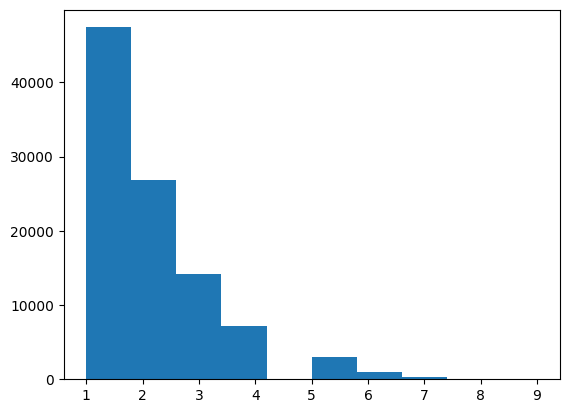

In [44]:
plt.hist(unpairdata['magnitude'])

In [45]:
unpairdata.save_to_disk("../../data/bowunnatural/unpairdata")

In [17]:
mixdistr

Dataset({
    features: ['question', 'source', 'modj', 'modk', 'tokj', 'tok', 'response_j', 'response_k', 'magnitude', '__index_level_0__', 'score_j', 'score_k'],
    num_rows: 50000
})

In [19]:
data1

Dataset({
    features: ['question', 'source', 'modj', 'modk', 'tokj', 'tok', 'response_j', 'response_k', 'magnitude', '__index_level_0__', 'score_j', 'score_k'],
    num_rows: 170019
})

In [18]:
# mixdistr.save_to_disk("../../data/bowunnatural/mixedtrain")